# Web-scraping for data collection

In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess

class YourSpider(scrapy.Spider):
    name = 'spider_one'
    
    def start_requests(self):
        url_start = "https://www.99.co/singapore/rent"
        yield scrapy.Request(url = url_start, callback = self.parse)

    def parse(self, response):
        properties =response.xpath("//div[@class = '_17qrb WgBDo']")
        
        for prop in properties:
            title = prop.xpath(".//div[@class = '_2kH6B']/a/text()").extract()
            detailed_link = prop.xpath(".//div[@class = '_2kH6B']/a/@href").extract()
            detailed_link_full = "https://www.99.co" + detailed_link[0]            
            
            yield response.follow(url = detailed_link_full,callback = self.parse_details)
            
        next_url = response.xpath("//div[@class = 'SearchPagination']//li[@class= 'next']/a/@href").extract()
        
        if next_url:
            next_url = "https://www.99.co" + next_url[0]

            yield response.follow(url = next_url, callback=self.parse)
        
            
    def parse_details(self, response):
        price = response.xpath("//div[@id = 'price']/h2/text()").extract()
        title = response.xpath("//div[@class = '_1p49F']/h1/text()").extract()
        beds_bathroom_size=response.xpath("//div[@class = '_3gg1z']/p/text()").extract()
       
        location = response.xpath("//div[@class = '_1p49F']/p/span/text()").extract()
        
        if len(location) == 3:
            location_granular = location[2][1:]
        else:
            location_granular = location[0][1:]
        
        mid_page_details = response.xpath("//div[@class = '_3r4yN XCAFU']/text()").extract()
                
        list_of_amenities = response.xpath("//div[@class = '_3atmT']/p/text()").extract()
        output_list.append((price[0], title[0], beds_bathroom_size[0],beds_bathroom_size[1], beds_bathroom_size[2],location_granular,
                              mid_page_details,list_of_amenities
                             ))
            
            
output_list = []
process = CrawlerProcess()
process.crawl(YourSpider)
process.start() 

In [3]:
len(output_list)

7467

#### Over 7000 Apartment postings were scraped with the following details:
#### Title of the post
#### Monthly charge of the apartment
#### Number of beds and bathrooms in the apartment
#### Size of the apartment in sqft
#### Location of the apartment (District)
#### Amenities in the bulding of the apartment
#### Other details like whether the apartment is fully furnished, partially furnished or unfurnished

In [1]:
import pandas as pd
df = pd.DataFrame(output_list, columns = ["Price per month", "Title", "Beds", "Bathrooms",
                                          "Size",
                                           "Location", "Apartment details", "Amenities"])

# Storing the Scraped data in a Dataframe

NameError: name 'output_list' is not defined

In [6]:
df.head()

,Price per month,Title,Beds,Bathrooms,Size,Location,Apartment details,Amenities
0,"$9,000/mo",5 Bed House for Rent in Hillcrest Villa,5 Beds,4 Baths,"2,917 sqft (built-up)",Newton / Novena (D11),"[Partial, 2009, 99-year leasehold, 2 mins ago,...","[Clubhouse, Stove, Walk in closet, Oven, Parki..."
1,"$3,050/mo",Studio Condo for Rent in Duo Residences / Duo ...,Studio,1 Bath,527 sqft,Beach Road / Bugis / Rochor (D7),"[$5.79 psf, High (31 total), Fully, Sea view, ...","[Function room, Rooftop pool, Jacuzzi, Oven, O..."
2,"$3,000/mo",2 Bed Condo for Rent in Regentville,2 Beds,2 Baths,980 sqft,Hougang / Punggol / Sengkang (D19),"[$3.06 psf, Fully, 2000, 99-year leasehold, Co...","[Fun pool, Clubhouse, Renovated, Aircon, Swimm..."
3,"$7,000/mo",3 Bed Condo for Rent in 8 St Thomas,3 Beds,2 Baths,"1,152 sqft",Orchard / River Valley (D9),"[$6.08 psf, Mid (35 total), Unfurnished, Pool ...","[Fitness corner, Fibre ready, Aircon, Closet, ..."
4,"$10,500/mo",5 Bed House for Rent in Greenwood Mews,5 Beds,4 Baths,"3,175 sqft (built-up)",Newton / Novena (D11),"[$3.31 psf, $3.31 psf, Partial, 2016, 103-year...","[Bomb shelter, Bathtub, Aircon, Dishwasher, Fr..."


In [546]:
df.to_csv("21 june.csv")

# Data Cleaning and Exploration

In [1]:
import pandas as pd
df = pd.read_csv("21 june.csv")
df = df.drop("Unnamed: 0",1)

In [2]:
df["Price per month"].str.extract(r'(/mo)').isnull().values.any()

False

#### All prices are in per month format. There is no instance of price which is yearly or weekly rather than monthly,

In [3]:
def remove_comma(x):
    if "," not in x:
        return int(x)
    else:
        output = ""
        for ch in x:
            if ch != ",":
                output = output+ch
        return int(output)
    
# The function above takes a string as input and returns the string with all commas deleted (if any)

In [4]:
df["Price per month"] =df["Price per month"].str.extract(r'([0-9,]+)') # Extracing all digits and commas from price
df["Price per month"] =df["Price per month"].map(remove_comma) # Removing commas from price

In [5]:
df["Price per month"].isnull().sum()

0

In [6]:
df["Beds"] =df["Beds"].str.extract(r'(\d+) Bed') 
df["Bathrooms"] =df["Bathrooms"].str.extract(r'(\d+) Bath')
df["Size"] = df["Size"].str.extract(r'(\S+) sqft')
# Extracting digits for Beds, Bathrooms and Size
df["Size"] =df["Size"].map(remove_comma)

In [7]:
df["Gym"] = df['Amenities'].map(lambda x: "yes" if 'Gym' in x else "no")
df["Swimming Pool"] = df['Amenities'].map(lambda x: "yes" if 'Swimming pool' in x else "no")

#### Drawing on my experience in apartment-hunting, Gym and Swimming Pool are the most import amenities which property seekers look for. As such, I have created Binary Variables for both presence of Gym and presence of Swimming pool using the list of amenities.

In [8]:
df.head()

,Price per month,Title,Beds,Bathrooms,Size,Location,Apartment details,Amenities,Gym,Swimming Pool
0,12000,3 Bed Condo for Rent in 3 Orchard By-The-Park,3,3,1862,Tanglin / Holland (D10),"['$6.44 psf', 'High (25 total)', 'Partial', 'G...","['Lounge', 'Pool deck', 'Pavilion', 'Security'...",yes,yes
1,3850,2 Bed Condo for Rent in Park Place Residences ...,2,2,678,Eunos / Geylang / Paya Lebar (D14),"['$5.68 psf', 'High (17 total)', 'Fully', 'Cit...","['City view', 'Patio / pes', 'Renovated', 'Air...",no,no
2,12200,4 Bed Condo for Rent in Skyline @ Orchard Boul...,4,3,2067,Orchard / River Valley (D9),"['$5.9 psf', 'High (33 total)', 'Unfurnished',...","['Clubhouse', 'City view', 'Bathtub', 'Renovat...",no,yes
3,8900,4 Bed Condo for Rent in Rosevale,4,3,2615,Newton / Novena (D11),"['$3.4 psf', 'Partial', '2003', 'Freehold', 'A...","['Aircon', 'Gym', 'Pool deck', 'Swimming pool'...",yes,yes
4,7000,3 Bed Condo for Rent in 8 St Thomas,3,2,1152,Orchard / River Valley (D9),"['$6.08 psf', 'Mid (35 total)', 'Unfurnished',...","['Fitness corner', 'Fibre ready', 'Aircon', 'C...",yes,no


In [9]:
def furnishing(detail_string):
    if "Fully" in detail_string:
        return "Fully"
    elif "Partial" in detail_string:
        return "Fully"
    elif "Unfurnished" in detail_string:
        return "Unfurnished"
    return None

# The function above extracts details regarding furnishing from the 'Apartment details' column

In [10]:
df["Furnishing"]= df["Apartment details"].map(furnishing)

In [11]:
df = df.drop(["Amenities","Apartment details"],1) # Dropping these columns since all useful info has already been stored in other columns

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7461 entries, 0 to 7460
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Price per month  7461 non-null   int64 
 1   Title            7461 non-null   object
 2   Beds             7138 non-null   object
 3   Bathrooms        7435 non-null   object
 4   Size             7461 non-null   int64 
 5   Location         7461 non-null   object
 6   Gym              7461 non-null   object
 7   Swimming Pool    7461 non-null   object
 8   Furnishing       3246 non-null   object
dtypes: int64(2), object(7)
memory usage: 524.7+ KB


#### 'Furnishing' has a lot of null values. This is because of its absence in a lot of apartment postings. The column will be dropped.

#### 'Beds' has a lot of null values because a lot of postings were that of 'Studio apartments' which do not list the number of beds individually. This column will be dropped as Studio apartments are very different (in terms of price too) from normal apartments which is the focus of this project.

In [13]:
df=df.drop("Furnishing",1)
df = df.dropna()

In [14]:
df["Beds"] = df["Beds"].astype(int)
df["Bathrooms"] = df["Bathrooms"].astype(int)

In [15]:
df.head()

,Price per month,Title,Beds,Bathrooms,Size,Location,Gym,Swimming Pool
0,12000,3 Bed Condo for Rent in 3 Orchard By-The-Park,3,3,1862,Tanglin / Holland (D10),yes,yes
1,3850,2 Bed Condo for Rent in Park Place Residences ...,2,2,678,Eunos / Geylang / Paya Lebar (D14),no,no
2,12200,4 Bed Condo for Rent in Skyline @ Orchard Boul...,4,3,2067,Orchard / River Valley (D9),no,yes
3,8900,4 Bed Condo for Rent in Rosevale,4,3,2615,Newton / Novena (D11),yes,yes
4,7000,3 Bed Condo for Rent in 8 St Thomas,3,2,1152,Orchard / River Valley (D9),yes,no


In [16]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [17]:
df.describe()

,Price per month,Beds,Bathrooms,Size
count,7113.000000,7113.000000,7113.000000,7113.000000
mean,6131.734008,2.523127,2.342050,1525.852805
std,5773.694870,1.292470,1.312353,1509.093761
min,450.000000,1.000000,1.000000,0.000000
25%,3200.000000,2.000000,1.000000,700.000000
50%,4400.000000,2.000000,2.000000,1044.000000
75%,7000.000000,3.000000,3.000000,1701.000000
max,125000.000000,10.000000,10.000000,24503.000000


In [18]:
df.head()

,Price per month,Title,Beds,Bathrooms,Size,Location,Gym,Swimming Pool
0,12000,3 Bed Condo for Rent in 3 Orchard By-The-Park,3,3,1862,Tanglin / Holland (D10),yes,yes
1,3850,2 Bed Condo for Rent in Park Place Residences ...,2,2,678,Eunos / Geylang / Paya Lebar (D14),no,no
2,12200,4 Bed Condo for Rent in Skyline @ Orchard Boul...,4,3,2067,Orchard / River Valley (D9),no,yes
3,8900,4 Bed Condo for Rent in Rosevale,4,3,2615,Newton / Novena (D11),yes,yes
4,7000,3 Bed Condo for Rent in 8 St Thomas,3,2,1152,Orchard / River Valley (D9),yes,no


In [19]:
df.groupby('Gym').mean()

,Price per month,Beds,Bathrooms,Size
Gym,,,,
no,6972.974843,2.972597,2.676101,2069.825247
yes,5748.553714,2.318396,2.189892,1278.076530


In [20]:
df.groupby('Swimming Pool').mean()

,Price per month,Beds,Bathrooms,Size
Swimming Pool,,,,
no,6517.338953,2.585756,2.354651,1664.195349
yes,5770.590253,2.464470,2.330248,1396.286142


#### Strangely, the data tells us that places lacking Gyms and Swimming Pools cost more at an average than apartments with them

In [21]:
df["Price per month"].describe()

count      7113.000000
mean       6131.734008
std        5773.694870
min         450.000000
25%        3200.000000
50%        4400.000000
75%        7000.000000
max      125000.000000
Name: Price per month, dtype: float64

In [22]:
df[df["Price per month"] ==125000]

,Price per month,Title,Beds,Bathrooms,Size,Location,Gym,Swimming Pool
1706,125000,5 Bed House for Rent in Gallop Park Road,5,7,12000,Tanglin / Holland (D10),no,no
3505,125000,5 Bed House for Rent in Ladyhill Park,5,6,12000,Tanglin / Holland (D10),no,yes
3868,125000,6 Bed House for Rent in Nassim Road,6,8,13000,Tanglin / Holland (D10),no,no


#### The dataset consists of a few houses which have a very high value, and are usually without these amenities. These houses are confounding the effect of amenities (and perhaps even location as central parts of Singapore do not have many houses) on price.

#### All instances of houses will be removed from the dataset

In [23]:
def is_house(x):
    if "House" in x or "house" in x:
        return None
    else:
        return x

In [24]:
df["Title"] = df["Title"].map(is_house)
df = df.dropna()

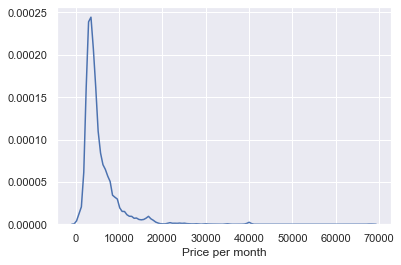

In [25]:
sns.distplot(df["Price per month"], hist= False)

#### There are still lots of outliers in terms of Price. The prices seem astonishing for a month in an apartment. Either these numbers have been included erroneously, or these are rare super-luxury buildings. These outliers will be removed.

In [26]:
q75,q25 = np.percentile(df["Price per month"],[75,25])
iqr = q75-q25

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
lower, upper

(-1750.0, 11450.0)

In [27]:
df[df["Price per month"] < lower] = np.nan
df[df["Price per month"] > upper] = np.nan

In [28]:
df["Price per month"].isnull().sum()

420

In [29]:
print("Before outlier removal",df.shape)
df = df.dropna()
print("After outlier removal",df.shape)

Before outlier removal (6493, 8)
After outlier removal (6073, 8)


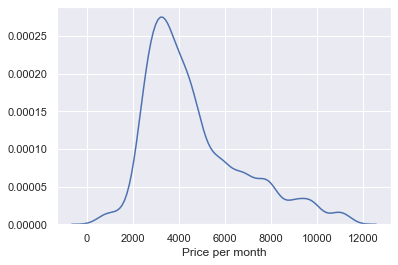

In [30]:
sns.distplot(df["Price per month"], hist= False)

In [31]:
df.groupby('Gym').mean()

,Price per month,Beds,Bathrooms,Size
Gym,,,,
no,3688.434219,2.230071,1.894362,1023.963707
yes,4969.964901,2.194040,2.041943,1110.988962


In [32]:
df.groupby('Swimming Pool').mean()

,Price per month,Beds,Bathrooms,Size
Swimming Pool,,,,
no,4236.227041,2.075802,1.823615,961.317784
yes,4980.771403,2.308201,2.153500,1194.022229


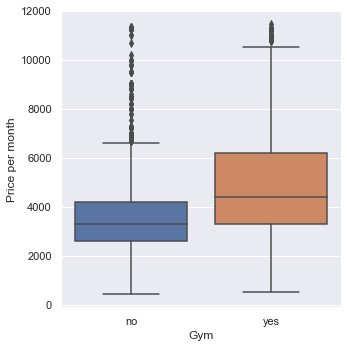

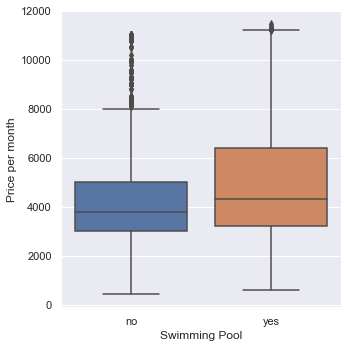

In [33]:
sns.catplot(x="Gym", y="Price per month",  kind="box", data=df)
sns.catplot(x="Swimming Pool", y="Price per month",  kind="box", data=df)

#### After the removal of outliers and house, we notice that presence of amenities like Gym and Swimming Pool has a postitive effect on the price

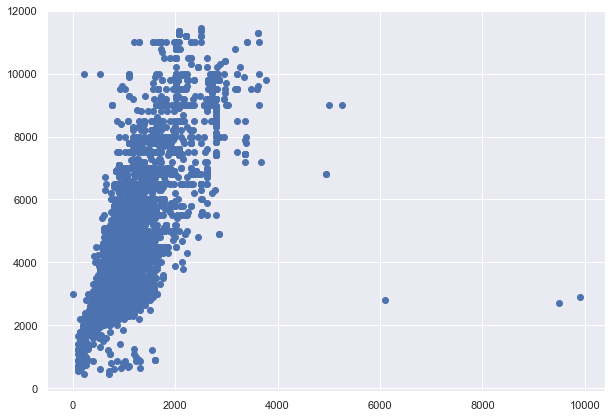

In [34]:
fig=plt.figure(figsize=(10,7))
plt.scatter(x = df["Size"], y = df["Price per month"])

In [35]:
df[df["Size"] >6000]

,Price per month,Title,Beds,Bathrooms,Size,Location,Gym,Swimming Pool
707,2800.0,1 Bed Condo for Rent in 80 Sophia Road,1.0,2.0,6106.0,Orchard / River Valley (D9),no,no
5431,2900.0,HDB Flat for Rent in 112 Jurong East Street 13,3.0,2.0,9903.0,Boon Lay / Jurong / Tuas (D22),no,no
5569,2700.0,HDB Flat for Rent in 710 Clementi West Street 2,2.0,2.0,9494.0,Buona Vista / West Coast / Clementi (D5),no,no


#### There are some instances with a very high number for size. These numbers seem unbelieveable, more so for an apartment ...... especially in Singapore. These outliers will also be removed

In [36]:
df[df["Size"] > 4000] = np.nan
df[df["Size"] < 100] = np.nan
print("Before outlier removal",df.shape)
df = df.dropna()
print("After outlier removal",df.shape)

Before outlier removal (6073, 8)
After outlier removal (6065, 8)


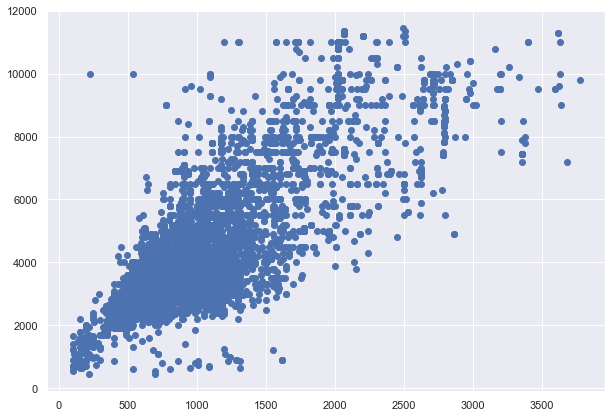

In [37]:
fig=plt.figure(figsize=(10,7))
plt.scatter(x = df["Size"], y = df["Price per month"])

In [38]:
df.describe()

,Price per month,Beds,Bathrooms,Size
count,6065.000000,6065.000000,6065.000000,6065.000000
mean,4643.395713,2.201814,2.002803,1082.789283
std,2138.046405,0.960721,0.907219,569.041150
min,450.000000,1.000000,1.000000,100.000000
25%,3100.000000,1.000000,1.000000,678.000000
50%,4000.000000,2.000000,2.000000,936.000000
75%,5800.000000,3.000000,2.000000,1303.000000
max,11450.000000,6.000000,6.000000,3778.000000


In [39]:
pd.pivot_table(df, index = ["Location"], values = "Price per month", aggfunc = "mean").sort_values("Price per month")

,Price per month
Location,
Seletar / Yio Chu Kang (D28),2761.400000
Pasir Ris / Tampines (D18),2815.628571
Sembawang / Yishun (D27),2831.655738
Mandai / Upper Thomson (D26),2935.714286
Changi Airport / Changi Village (D17),2977.826087
Balestier / Toa Payoh (D12),2992.609091
Hougang / Punggol / Sengkang (D19),3020.640523
Bedok / Upper East Coast (D16),3100.312500
Ang Mo Kio / Bishan / Thomson (D20),3187.765152


#### As expected, central areas of Singapore have a higher apartment price at an average as compared to suburban areas

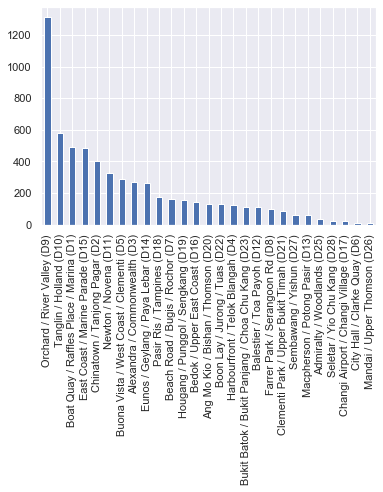

In [40]:
from matplotlib.ticker import FuncFormatter
import matplotlib.mlab as mlab
import matplotlib.cbook as cbook
import matplotlib.ticker as ticker

sns.set(font_scale=1)
count_classes = pd.value_counts(df['Location'], sort = True)
count_classes.plot(kind = 'bar', rot=90)



#### The instances are highly dominated by central locations like Orchard, Raffles Place etc. This can potentially affect the model in predicting apartment prices in suburban Singapore.

In [41]:
df = df.drop("Title",1) #Dropping the titles as they will provide no assistance in modelling

In [42]:
pd.set_option('display.max_rows', None)
pd.pivot_table(df, index = ["Location", "Swimming Pool","Gym"], values = "Price per month", aggfunc = "mean")

Price per month
Location                                          Swimming Pool Gym                 
Admiralty / Woodlands (D25)                       no            no       2232.142857
                                                                yes      5287.500000
                                                  yes           yes      4300.000000
Alexandra / Commonwealth (D3)                     no            no       2932.760563
                                                                yes      3723.607143
                                                  yes           yes      5090.758621
Ang Mo Kio / Bishan / Thomson (D20)               no            no       2305.937500
                                                                yes      4011.764706
                                                  yes           yes      3474.000000
Balestier / Toa Payoh (D12)                       no            no       2872.029412
                                                                yes      3048.947368
                                                  yes           no       2600.000000
                                                                yes      3061.963636
Beach Road / Bugis / Rochor (D7)                  no            no       3472.121212
                                                                yes      5192.863636
                                                  yes           no       3150.000000
                                                                yes      3919.473684
Bedok / Upper East Coast (D16)                    no            no       2506.115385
                                                                yes      3400.000000
                                                  yes           no       2599.666667
                                                                yes      3465.839080
Boat Quay / Raffles Place / Marina (D1)           no            no       4373.347826
                                                                yes      5206.887363
                                                  yes           no       5000.000000
                                                                yes      4976.854369
Boon Lay / Jurong / Tuas (D22)                    no            no       2911.236364
                                                                yes      3680.769231
                                                  yes           yes      3394.700000
Bukit Batok / Bukit Panjang / Choa Chu Kang (D23) no            no       2889.511628
                                                                yes      3607.333333
                                                  yes           no       4128.428571
                                                                yes      3316.166667
Buona Vista / West Coast / Clementi (D5)          no            no       3530.945205
                                                                yes      5422.622642
                                                  yes           no       4223.823529
                                                                yes      4123.565891
Changi Airport / Changi Village (D17)             no            no       2600.000000
                                                                yes      3180.909091
                                                  yes           no       3500.000000
                                                                yes      2740.000000
Chinatown / Tanjong Pagar (D2)                    no            no       2930.000000
                                                                yes      4228.163265
                                                  yes           no       3192.857143
                                                                yes      6003.670588
City Hall / Clarke Quay (D6)                      no            no       4383.333333
Clementi Park / Upper Bukit Timah (D21)           no            no       3

#### The difference in availability of Gym and Swimming Pool leads to stark price differences in some areas, and not so much in other areas. However, there is no obvious pattern in terms of whether the location is in central Singapore or towards the suburbs affecting the demand for such amenities 

In [43]:
df.head()

,Price per month,Beds,Bathrooms,Size,Location,Gym,Swimming Pool
1,3850.0,2.0,2.0,678.0,Eunos / Geylang / Paya Lebar (D14),no,no
3,8900.0,4.0,3.0,2615.0,Newton / Novena (D11),yes,yes
4,7000.0,3.0,2.0,1152.0,Orchard / River Valley (D9),yes,no
5,3600.0,2.0,2.0,786.0,East Coast / Marine Parade (D15),yes,no
6,4350.0,1.0,1.0,1743.0,East Coast / Marine Parade (D15),no,yes


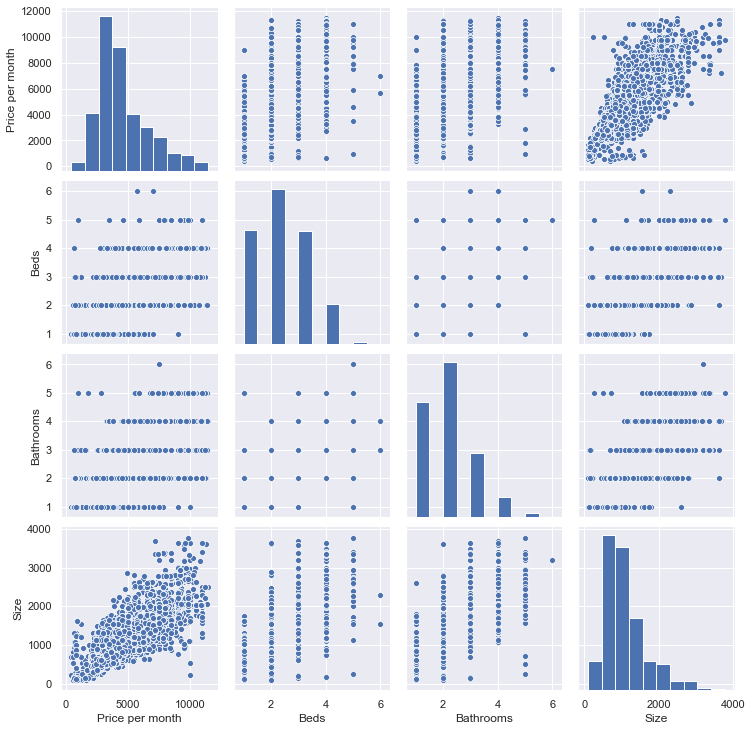

In [44]:
sns.pairplot(df)

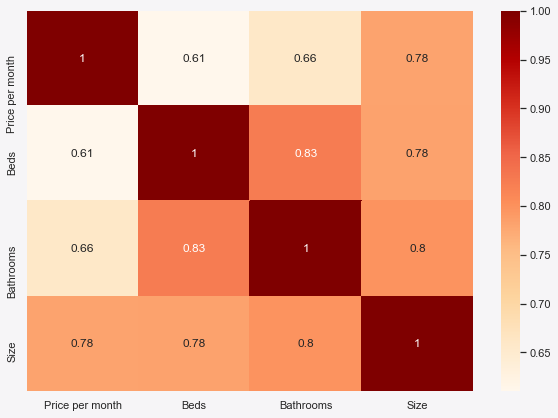

In [45]:
fig=plt.figure(figsize=(10,7))
backgroundcolor='#f6f5f7'
fig.patch.set_facecolor(backgroundcolor)
sns.heatmap(data=df.corr(),annot=True,cmap='OrRd')

#### Number of bathrooms, number of bedrooms and the size of the apartment are highly correlated with each other. This will be taken into consideration during the modelling stage

# Modelling

In [46]:
df_dum = pd.get_dummies(df) 

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X= df_dum.drop("Price per month", 1)

In [50]:
y = df_dum["Price per month"].values

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [52]:
import statsmodels.api as sm

In [53]:
X_sm = X = sm.add_constant(X)

In [54]:
model1 = sm.OLS(y,X_sm)

In [55]:
model1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     669.9
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:18:22   Log-Likelihood:                -50588.
No. Observations:                6065   AIC:                         1.012e+05
Df Residuals:                    6033   BIC:                         1.015e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                        238.0952     20.828     11.432      0.000     197.265     278.925
Beds                                                         262.4665     27.134      9.673      0.000     209.275     315.658
Bathrooms                                                    253.3258     28.756      8.809      0.000     196.953     309.698
Size                                                           2.1758      0.043     50.187      0.000       2.091       2.261
Location_Admiralty / Woodlands (D25)                       -1289.6733    166.487     -7.746      0.000   -1616.048    -963.298
Location_Alexandra / Commonwealth (D3)                       309.1422     64.881      4.765      0.000     181.952     436.333
Location_Ang Mo Kio / Bishan / Thomson (D20)                -610.0557     89.182     -6.841      0.000    -784.884    -435.227
Location_Balestier / Toa Payoh (D12)                        -302.3714     97.149     -3.112      0.002    -492.818    -111.925
Location_Beach Road / Bugis / Rochor (D7)                    630.9011     82.067      7.688      0.000     470.020     791.783
Location_Bedok / Upper East Coast (D16)                     -408.1671     85.734     -4.761      0.000    -576.236    -240.099
Location_Boat Quay / Raffles Place / Marina (D1)            1486.0398     53.912     27.564      0.000    1380.354    1591.726
Location_Boon Lay / Jurong / Tuas (D22)                     -529.1355     89.531     -5.910      0.000    -704.648    -353.623
Location_Bukit Batok / Bukit Panjang / Choa Chu Kang (D23)  -950.9952     97.112     -9.793      0.000   -1141.369    -760.621
Location_Buona Vista / West Coast / Clementi (D5)            216.4170     63.248      3.422      0.001      92.428     340.406
Location_Changi Airport / Changi Village (D17)             -1164.5361    206.139     -5.649      0.000   -1568.643    -760.430
Location_Chinatown / Tanjong Pagar (D2)                     1573.4168     56.765     27.718      0.000    1462.136    1684.697
Location_City Hall / Clarke Quay (D6)                       2080.4821    284.889      7.303      0.000    1521.998    2638.966
Location_Clementi Park / Upper Bukit Timah (D21)            -470.1219    111.461     -4.218      0.000    -688.626    -251.618
Location_East Coast / Marine Parade (D15)                     21.0326     51.536      0.408      0.683     -79.995     122.061
Location_Eunos / Geylang / Paya Lebar (D14)                  220.9426     66.247      3.335      0.001      91.076     350.810
Location_Farrer Park / Serangoon Rd (D8)                     253.3085    101.500      2.496      0.013      54.331     452.286
Location_Harbourfront / Telok Blang

In [56]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

### Multiple Linear Regression

In [57]:
lm = LinearRegression()

In [58]:
np.mean(cross_val_score(lm, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 5))

-767.6201203577378

### Lasso Regression

In [59]:
lm_lasso = Lasso()

In [60]:
np.mean(cross_val_score(lm_lasso, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 5))

-766.5673688364935

In [61]:
alpha = []
error = []

In [ ]:
for i in range(1,1000):
    alpha.append(i/100)
    lm_las = Lasso(alpha = (i/100))
    error.append(np.mean(cross_val_score(lm_las, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 5)))

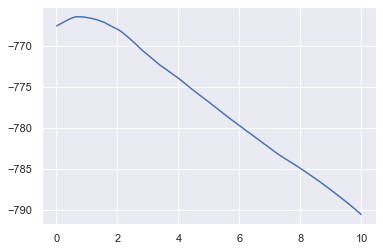

In [63]:
plt.plot(alpha,error)

In [64]:
err = tuple(zip(alpha, error))

In [65]:
df_lasso_error = pd.DataFrame(err, columns = ["alpha","error"])

In [66]:
df_lasso_error[df_lasso_error.error == max(df_lasso_error.error)]

,alpha,error
65,0.66,-766.469511


In [67]:
#Alpha = 35.68

### Random Forests

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
rf =  RandomForestRegressor()

In [70]:
np.mean(cross_val_score(rf, X_train, y_train, scoring ="neg_mean_absolute_error", cv= 5))

-413.6012803913046

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
parameters = {"n_estimators":[50,100,200,300,500],'criterion':['mae'],'max_features':['auto','sqrt','log2']}

In [73]:
gs  = GridSearchCV(rf, parameters, scoring = "neg_mean_absolute_error", cv = 3)

In [74]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mae'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300, 500]},
             scoring='neg_mean_absolute_error')

In [75]:
gs.best_score_ ,gs.best_params_



(-424.0643216105711,
 {'criterion': 'mae', 'max_features': 'auto', 'n_estimators': 500})

In [76]:
gs.best_estimator_

RandomForestRegressor(criterion='mae', n_estimators=500)

### Testing the final models

In [77]:
lm = lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)

In [78]:
lm_lasso = Lasso(alpha = 35.68)
lm_lasso.fit(X_train, y_train)
lm_lasso_pred = lm_lasso.predict(X_test)

In [79]:
lm_lasso2 = Lasso(alpha = 0.7)
lm_lasso2.fit(X_train, y_train)
lm_lasso2_pred = lm_lasso2.predict(X_test)

In [80]:
rf = RandomForestRegressor(n_estimators =500 , criterion ="mae" , max_features = "auto")
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [81]:
from sklearn.metrics import mean_absolute_error

In [82]:
mean_absolute_error(y_test,lm_pred)

762.6485771528695

In [83]:
mean_absolute_error(y_test,lm_lasso_pred)

827.9334659590787

In [84]:
mean_absolute_error(y_test,rf_pred)

403.69140560593576

In [85]:
mean_absolute_error(y_test,lm_lasso2_pred)

760.4625817616804

#### The Random Forest Regressor tuned using GridSearchCV produces the best test results. This will be the final model

In [86]:
import pickle

In [87]:
filename = 'finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))